In [92]:
# Framework:
#
# 1. Individual stock:
#      ---- GENERAL INPUT: only one sticker
#   1.0. Historical price plot
#   1.1. Parameter estimates:
#      - plot_1: mean (2/5/10 years rolling windows in one plot)
#      - plot_2: volatility (2/5/10 years rolling windows in one plot)
#   1.2. VaR/ES
#      - input: VaR prob, ES prob, rolling windows*, horizon, method**
#      - plot: VaR and ES in one plot
# 2. Portfolio: (portfolio lognormal/position normal)
#      ---- GENERAL INPUT: stickers, initial investment, weights
#   2.0. Historical price plot
#   2.1. Parameter estimates:
#      - plot_1: mean (2/5/10 years rolling windows in one plot)
#      - plot_2: volatility (2/5/10 years rolling windows in one plot)
#   2.2. VaR/ES (ASSUMPTION: portfolio following GBM)
#      - input: VaR prob, ES prob, rolling window*, horizon, method**
#      - plot: VaR and ES in one plot
#
#    * choose from 2/5/10 because parameters already computed above
#   ** choose from historical/parametric/MC
#  *** historical method: assumes relative price changes (log returns)
#      parametric/MC methods: assumes portfolio follow GBM

In [ ]:
# TODO:
#
# 1. Portfolio parameters (hw6)
# 2. Portfolio VaR/ES (hw6)
# 3. Historical method (hw7)
# 4. Monte Carlo (hw8)
# 5. Plot
# 6. Clean up input parameters for each method (global variable??)
#     - if need method to take parameters??

In [1]:
# import packages

import pandas_datareader.data as web
import datetime
import pandas as pd
import numpy as np
import scipy.stats as stat
import dateutil.relativedelta
import matplotlib.pyplot as plt
import sys

from __future__ import division

In [ ]:
##########################################################################################
################################### GENERAL METHODS ######################################
##########################################################################################

In [68]:
# Price plot
def price_plot(price, length):
    data = price[:length]
    plt.plot(data)
    plt.grid(True)
    plt.title('Historical price')
    plt.show()

In [3]:
# Calculate estimated parameters for GBM based on x year (in days) rolling windows
def gbm_est(prices, window_days):
    rtn = -np.diff(np.log(prices))
    rtnsq = rtn * rtn
    mubar = list(reversed(np.convolve(rtn, np.ones((window_days,))/window_days, mode='valid')))
    x2bar = list(reversed(np.convolve(rtnsq, np.ones((window_days,))/window_days, mode='valid')))
    var = x2bar - np.square(mubar)
    sigmabar = np.sqrt(np.maximum(var, np.zeros(len(var))))
    sigma = sigmabar / np.sqrt(1/252)
    mu = np.array(mubar)*252 + np.square(sigma)/2
    return rtn, mu, sigma, np.array(mubar), sigmabar

In [110]:
# TODO:
#   - define in a method
#   - better to be merged with plot_volatility in same method (2 plots needed: subplot?)
#   - fancy!!!!!! (legend, color, title, ...)
def plot_mu(mu1, mu2, mu3, index):
    length = min(len(mu1), len(mu2), len(mu3))
    mu = pd.DataFrame({'Mu_2': mu1[:length], 'Mu_5': mu2[:length], 'Mu_10': mu3[:length]}, index = index[:length])
    plt.plot(mu)
    plt.grid(True)
    plt.title('Return rate')
    plt.show()

In [109]:
# TODO:
#   - define in a method
#   - better to be merged with plot_mu in same method (2 plots needed: subplot?)
#   - fancy!!!!!! (legend, color, title, ...)
def plot_volatility(sigma1, sigma2, sigma3, index):
    length = min(len(sigma1), len(sigma2), len(sigma3))
    sigma = pd.DataFrame({'Sigma_2': sigma1[:length], 'Sigma_5': sigma2[:length], 'Sigma_10': sigma3[:length]}, index = index[:length])
    plt.plot(sigma)
    plt.grid(True)
    plt.title('Volatility')
    plt.show()

In [14]:
# Calculate t-day VaR with confidence degree p assuming gbm, --parametric method
# Using parameter estimated above 
def gbm_VaR(v0, mu, sigma, p, t):
    VaR = v0 - v0 * np.exp(sigma * np.sqrt(t) * stat.norm.ppf(1-p) + (mu - np.square(sigma)/2) * t)
    return VaR

In [19]:
# Calculate t-day ES with confidence degree p assuming gbm, --parametric method\
# Using parameter estimated above 
def gbm_ES(v0, mu, sigma, p, t):
    ES = v0 * (1 - np.array(stat.norm.cdf(stat.norm.ppf(1-p) - np.sqrt(t)*sigma)) * np.array(np.exp(mu*t)/(1-p)))
    return ES

In [ ]:
##########################################################################################
################################ PART 1: STOCK ANALYSIS ##################################
##########################################################################################

In [105]:
# Set up input

position_date_1 = datetime.datetime(2010, 12, 1)   # first day of plot
end_date_1 = datetime.datetime(2016, 12, 1)        # pick up a date for testing, may remove later and set today as default
ticker_1 = "AAPL"                                  # Stock ticker (string)

# VaR/ES input
v0_1 = 10000                                         # initial investment
VaR_prob_1 = 0.99
ES_prob_1 = 0.975
window_1 = 2                                         # using 2 years historical data for estimation
horizon_days_1 = 5                                   # 5 days VaR/ES

# Not input, prepared for further analysis
window_days_1 = window_1 * 252                         # convert to days
horizon_1 = horizon_days_1/252                         # convert to years
start_date_1 = position_date_1 - dateutil.relativedelta.relativedelta(years = 10)      # fetch data starting from start_date
price_1 = web.DataReader(ticker_1, 'yahoo', start_date_1, end_date_1)['Adj Close'].sort_index(ascending = False)  
plot_length_1 = len(price_1[price_1.index >= position_date_1])
index_1 = price_1.index

In [65]:
def stock_price_plot():
    price_plot(price_1, plot_length_1)

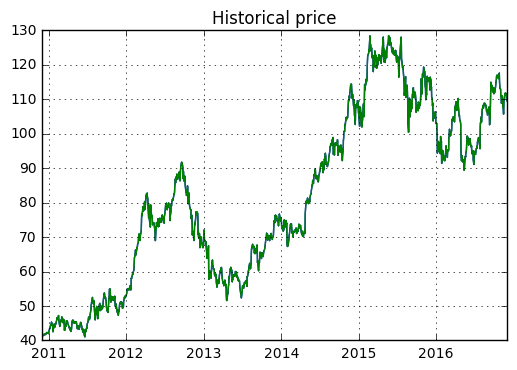

In [69]:
stock_price_plot()

In [4]:
# test with AAPL 
# may need to be defined as a method and used in "plot_mu" & "plot_volatility" 
rtn_12, mu_12, sigma_12, mubar_12, sigmabar_12 = gbm_est(price_1, 2*252)
rtn_15, mu_15, sigma_15, mubar_15, sigmabar_15 = gbm_est(price_1, 5*252)
rtn_110, mu_110, sigma_110, mubar_110, sigmabar_110 = gbm_est(price_1, 10*252)

In [5]:
rtn_12   # compare with values computed in Matlab

array([-0.00936327, -0.0084693 , -0.00098642, ..., -0.17208061,
        0.01855391, -0.02222338])

In [6]:
mu_12   # compare with values computed in Matlab

array([ 0.0912205 ,  0.12017773,  0.11768592, ...,  0.01951603,
        0.03152471,  0.02877686])

In [7]:
sigma_12   # compare with values computed in Matlab

array([ 0.57278381,  0.57312372,  0.57305406, ...,  0.25495355,
        0.25395576,  0.25402751])

In [8]:
mu_15   # compare with values computed in Matlab

array([ 0.54276587,  0.54782728,  0.5456464 , ...,  0.20579393,
        0.19721042,  0.19689942])

In [9]:
sigma_15   # compare with values computed in Matlab

array([ 0.47007218,  0.46995073,  0.46989827, ...,  0.26228784,
        0.26189725,  0.26190831])

In [10]:
mu_110   # compare with values computed in Matlab

array([ 0.45914206,  0.46168227,  0.45938395, ...,  0.2782567 ,
        0.27969277,  0.27622896])

In [11]:
sigma_110   # compare with values computed in Matlab

array([ 0.43933745,  0.43927416,  0.43924459, ...,  0.33086901,
        0.33079546,  0.33072318])

In [111]:
def plot_mu_stock():
    plot_mu(mu_12, mu_15, mu_110, index_1)

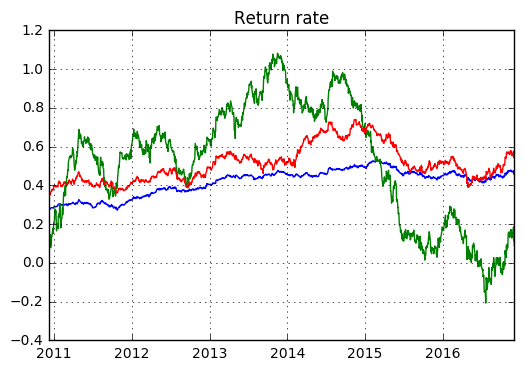

In [112]:
plot_mu_stock()

In [113]:
def plot_volatility_stock():
    plot_volatility(sigma_12, sigma_15, sigma_110, index_1)

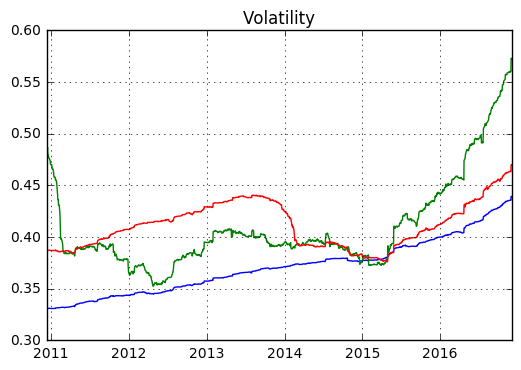

In [114]:
plot_volatility_stock()

In [15]:
# ONLY for testing, not to be calculated all three
VaR_12 = gbm_VaR(v0_1, mu_12, sigma_12, VaR_prob_1, horizon_1)
VaR_15 = gbm_VaR(v0_1, mu_15, sigma_15, VaR_prob_1, horizon_1)
VaR_110 = gbm_VaR(v0_1, mu_110, sigma_110, VaR_prob_1, horizon_1)

In [16]:
VaR_12   # compare with values computed in Matlab

array([ 1723.2832322 ,  1719.4808539 ,  1719.69467144, ...,   803.87256717,
         798.62680794,   799.34812896])

In [17]:
VaR_15   # compare with values computed in Matlab

array([ 1353.75166064,  1352.52936965,  1352.75068763, ...,   792.3241649 ,
         792.69510665,   792.78580512])

In [18]:
VaR_110   # compare with values computed in Matlab

array([ 1278.29305978,  1277.66775266,  1277.97874878, ...,   987.62631049,
         987.14794838,   987.54960425])

In [20]:
# ONLY for testing, not to be calculated all three
ES_12 = gbm_ES(v0_1, mu_12, sigma_12, ES_prob_1, horizon_1)
ES_15 = gbm_ES(v0_1, mu_15, sigma_15, ES_prob_1, horizon_1)
ES_110 = gbm_ES(v0_1, mu_110, sigma_110, ES_prob_1, horizon_1)

In [21]:
ES_12   # compare with values computed in Matlab

array([ 1727.83150326,  1724.03209912,  1724.24561802, ...,   806.96742872,
         801.71398268,   802.43574208])

In [22]:
ES_15   # compare with values computed in Matlab

array([ 1358.12207209,  1356.89982799,  1357.12078745, ...,   795.49179998,
         795.85897408,   795.94974445])

In [23]:
ES_110   # compare with values computed in Matlab

array([ 1282.54671021,  1281.92137   ,  1282.23205653, ...,   991.30403569,
         990.82530106,   991.22623501])

In [24]:
# inner method to do plot givin parameters
def plot_VaR_ES_1(v0, mu, sigma, VaR_prob, ES_prob, horizon, plot_length):
    VaR = gbm_VaR(v0, mu, sigma, VaR_prob, horizon)
    ES = ES = gbm_ES(v0, mu, sigma, ES_prob, horizon)
    length = min(len(VaR), len(ES), plot_length)
    VaR_ES = pd.DataFrame({'VaR': VaR[:length], 'ES': ES[:length]}, index = price_1.index[:plot_length])
    plt.plot(VaR_ES)
    plt.grid(True)
    plt.title('VaR/ES')
    plt.show()

In [25]:
# plot method, select from different rolling windows, must be 2/5/10, if not, raise error message and exit
def plot_VaR_ES(v0, VaR_prob, ES_prob, window, horizon, plot_length):
        if window == 2:
            plot_VaR_ES_1(v0, mu_12, sigma_12, VaR_prob, ES_prob, horizon, plot_length)
        elif window == 5:
            plot_VaR_ES_1(v0, mu_15, sigma_15, VaR_prob, ES_prob, horizon, plot_length)
        elif window == 10:
            plot_VaR_ES_1(v0, mu_110, sigma_110, VaR_prob, ES_prob, horizon, plot_length)
        else :
            sys.exit('Error!')


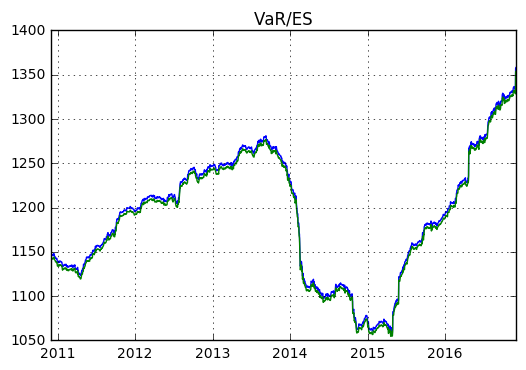

In [27]:
# test with 5 year window
# TO BE FIXED: first running, y-axis is (-200, 1400); second running, y-axis is (1050, 1400).
#              How to make first running to be (1050, 1400) ?
plot_VaR_ES(v0_1, VaR_prob_1, ES_prob_1, 5, horizon_1, plot_length_1)

In [31]:
# test with 4 year rolling window (expect to show error message and plot nothing)
# QUESTION: How to show error message on website?
#           Does it cause problem while actual running website?
plot_VaR_ES(v0_1, VaR_prob_1, ES_prob_1, 4, horizon_1, plot_length_1)

SystemExit: Error!

In [28]:
##########################################################################################
######################## PART 2: PORTFOLIO ANALYSIS ######################################
##########################################################################################

In [91]:
# Set up input

position_date = datetime.datetime(2010, 12, 1)   # first day of plot
end_date = datetime.datetime(2016, 12, 1)        # pick up a date for testing, may remove later and set today as default
tickers_string = "AAPL,AMZN"   # a string; as an example, tickers separated by comma.
tickers_list = tickers_string.split(",")  # split the string by the commas into a list of strings
weight_string = "0.5,0.5"
weight_list = map(float, weight_string.split(","))  
    # split the string by the commas, and map each string in the resulting list into a float
    
# VaR/ES input
v0 = 10000                                         # initial investment
VaR_prob = 0.99
ES_prob = 0.975
window = 2                                         # using 2 years historical data for estimation
horizon_days = 5                                   # 5 days VaR/ES

# Not input, prepared for further analysis
window_days = window * 252                         # convert to days
horizon = horizon_days/252                         # convert to years
start_date = position_date - dateutil.relativedelta.relativedelta(years = 10)      # fetch data starting from start_date 
d={}
for ticker in tickers_list:
    d["{0}".format(ticker)] = web.DataReader(ticker, 'yahoo', start_date, end_date)['Adj Close'].rename(ticker)
df = pd.DataFrame(d).sort_index(ascending = False)  
plot_length = len(df[df.index >= position_date])

# Compute portfolio price
shares = np.round(np.divide(v0 * np.array(weight_list), np.array(df.ix[position_date])))
portfolio = pd.DataFrame({'Price': np.matmul(df, shares)}, index = df.index)

In [70]:
def portfolio_price_plot():
    price_plot(portfolio, plot_length)

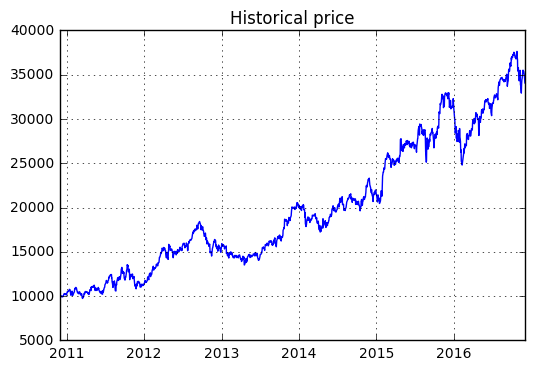

In [71]:
portfolio_price_plot()

In [93]:
rtn_2, mu_2, sigma_2, mubar_2, sigmabar_2 = gbm_est(portfolio['Price'], 2*252)
rtn_5, mu_5, sigma_5, mubar_5, sigmabar_5 = gbm_est(portfolio['Price'], 5*252)
rtn_10, mu_10, sigma_10, mubar_10, sigmabar_10 = gbm_est(portfolio['Price'], 10*252)

In [94]:
mu_2   # compare with values computed in Matlab

array([ 0.20749548,  0.18274213,  0.20662731, ...,  0.22924457,
        0.24001528,  0.23633342])

In [95]:
sigma_2   # compare with values computed in Matlab

array([ 0.7384571 ,  0.73726518,  0.73689307, ...,  0.23929098,
        0.23814282,  0.23824283])

In [96]:
mu_5   # compare with values computed in Matlab

array([ 0.37261709,  0.36135935,  0.36983656, ...,  0.25942936,
        0.24714662,  0.24894259])

In [97]:
sigma_5   # compare with values computed in Matlab

array([ 0.54587905,  0.54523384,  0.54499446, ...,  0.22708424,
        0.22621211,  0.22609329])

In [98]:
mu_10   # compare with values computed in Matlab

array([ 0.36076536,  0.3543388 ,  0.35754742, ...,  0.30769872,
        0.30932151,  0.30692182])

In [99]:
sigma_10   # compare with values computed in Matlab

array([ 0.47219201,  0.47181888,  0.47167716, ...,  0.31411692,
        0.31399916,  0.31398658])

In [115]:
# ONLY for testing, not to be calculated all three
VaR_2 = gbm_VaR(v0, mu_2, sigma_2, VaR_prob, horizon)
VaR_5 = gbm_VaR(v0, mu_5, sigma_5, VaR_prob, horizon)
VaR_10 = gbm_VaR(v0, mu_10, sigma_10, VaR_prob, horizon)

In [116]:
VaR_2   # compare with values computed in Matlab

array([ 2159.44779729,  2160.0993899 ,  2155.3839284 , ...,   717.29527056,
         711.76686726,   712.75413379])

In [117]:
VaR_5   # compare with values computed in Matlab

array([ 1600.73199888,  1600.77364113,  1598.68005661, ...,   673.9800647 ,
         673.5510146 ,   672.85053946])

In [118]:
VaR_10   # compare with values computed in Matlab

array([ 1391.07090991,  1391.08593747,  1390.12660177, ...,   931.75009816,
         931.1015354 ,   931.49520055])

In [119]:
# ONLY for testing, not to be calculated all three
ES_2 = gbm_ES(v0, mu_2, sigma_2, ES_prob, horizon)
ES_5 = gbm_ES(v0, mu_5, sigma_5, ES_prob, horizon)
ES_10 = gbm_ES(v0, mu_10, sigma_10, ES_prob, horizon)

In [120]:
ES_2   # compare with values computed in Matlab

array([ 2163.92733632,  2164.57901857,  2159.86639071, ...,   720.26716003,
         714.7291656 ,   715.71710788])

In [121]:
ES_5   # compare with values computed in Matlab

array([ 1605.26975183,  1605.30933847,  1603.21612804, ...,   676.8431123 ,
         676.40530518,   675.70383207])

In [122]:
ES_10   # compare with values computed in Matlab

array([ 1395.43233261,  1395.44562063,  1394.48611218, ...,   935.31765537,
         934.66839267,   935.06180086])

In [130]:
def historical(price, window_days, horizon_days):
    npaths = window_days - horizon_days
    ntrails = len(price) - window_days
    log_price = np.log(price)
    return_5days = log_price[:(len(price)-horizon_days)]

In [144]:
return_5days = (log_price[:len(portfolio)-horizon_days] - log_price[5:]).sort_index(ascending = False)  